In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
import xarray as xr
from numpy.polynomial.polynomial import Polynomial
import scipy.stats as stats
import warnings
from pymc import HalfCauchy, Model, Normal, sample

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
size = 200 # numero di osservazioni nel campione
true_intercept = 1 # alpha
true_slope = 2 # beta

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size) # sigma = 0.5

data = pd.DataFrame(dict(x=x, y=y))
data.head()

,x,y
0,0.000000,1.152359
1,0.005025,0.490058
2,0.010050,1.395326
3,0.015075,1.500433
4,0.020101,0.064683


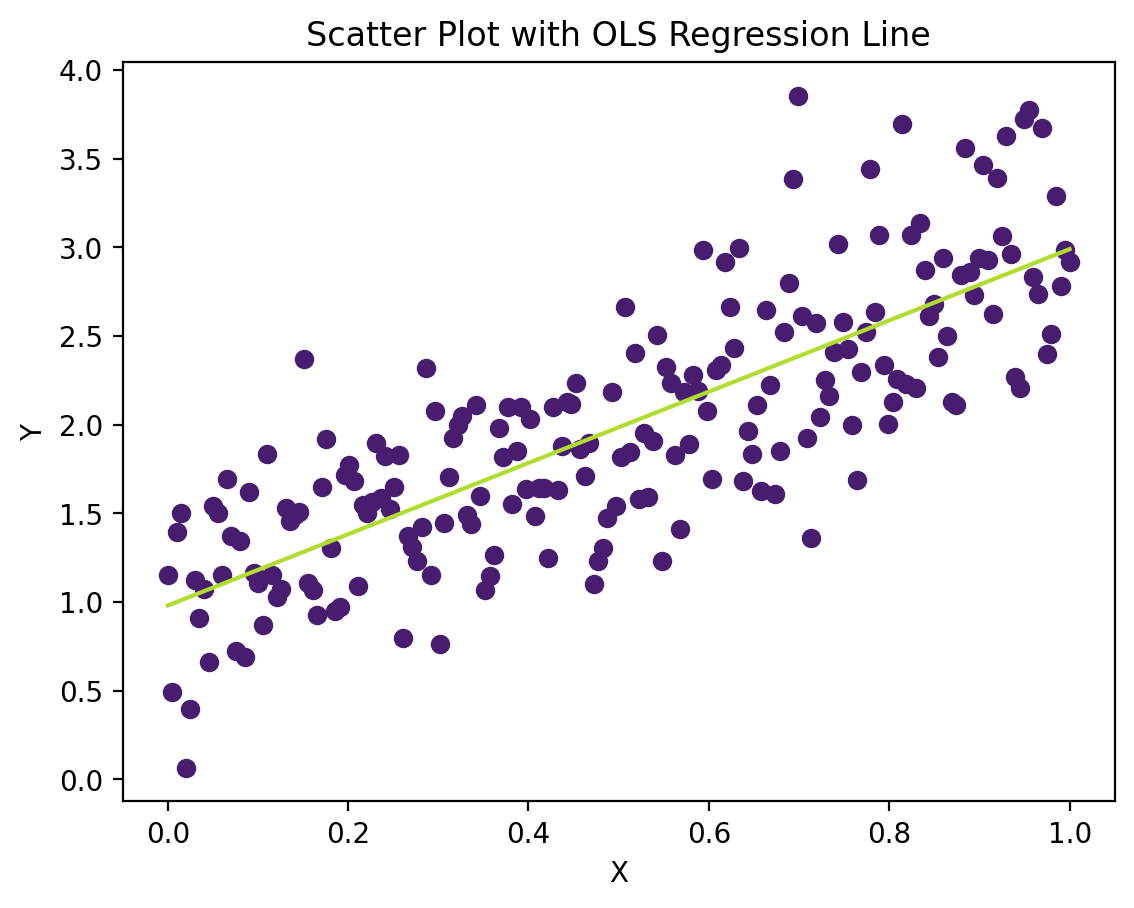

In [4]:
# Creating a scatter plot
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with OLS Regression Line")

# Fitting a linear regression
linear_regression = Polynomial.fit(data["x"], data["y"], 1)

# Plotting the regression line
plt.plot(data["x"], linear_regression(data["x"]), color="C3")
plt.show()

In [5]:
# Log-Gaussian likelihood 
def log_gaussian_likelihood(y, mu, sigma_squared):
    return stats.norm.logpdf(y, loc=mu, scale=np.sqrt(sigma_squared))

In [6]:
# Log-Gaussian prior
def log_gaussian_prior(param, mean=0, variance=1):
    return stats.norm.logpdf(param, loc=mean, scale=np.sqrt(variance))

In [7]:
# Log-Posterior calculation
def calc_log_posterior(a, b, y=y, x=x, sigma_squared=1.0):
    mu = a + b * x
    log_likelihood = log_gaussian_likelihood(y, mu, sigma_squared)
    log_prior_a = log_gaussian_prior(a)
    log_prior_b = log_gaussian_prior(b)
    return np.sum(log_likelihood) + log_prior_a + log_prior_b

In [8]:
# Brute-force grid search for posterior visualization
X1 = np.linspace(0, 3, 101)  # alpha (intercept)
X2 = np.linspace(0, 3, 100)  # beta (slope)
log_pp = np.zeros((101, 100))

k = 0
for x1 in X1:
    j = 0
    for x2 in X2:
        log_pp[k, j] = calc_log_posterior(x1, x2)
        j += 1
    k += 1

In [9]:
# To visualize in the original scale, we can exponentiate log_pp
pp = np.exp(log_pp - np.max(log_pp))  # Subtract the max for numerical stability

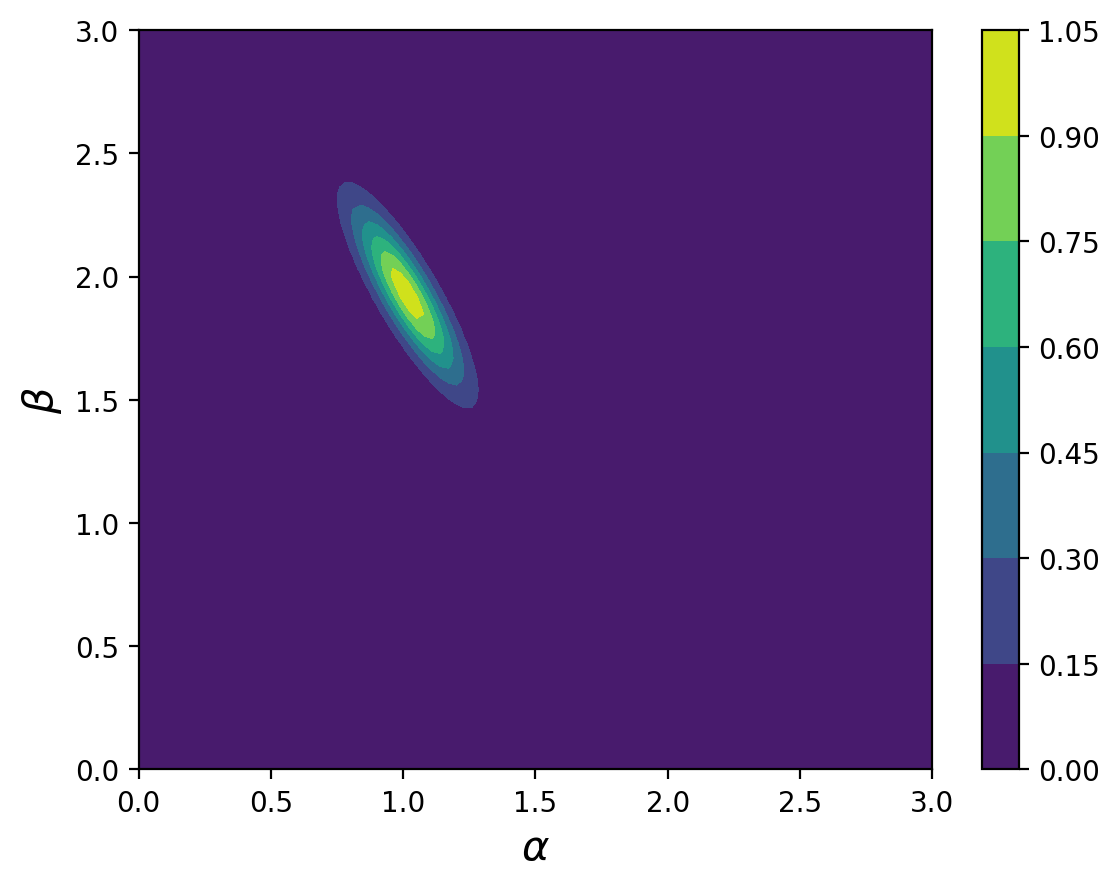

In [10]:
plt.contourf(X1, X2, pp.T)
plt.xlabel("$\\alpha$", size=15)
plt.ylabel("$\\beta$", size=15)
plt.colorbar()
plt.show()

In [11]:
with Model() as model:
    # Define priors
    alpha = pm.Normal("alpha", sigma=1)
    beta = pm.Normal("beta", sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=5)
    # Define likelihood
    pm.Normal("y_obs", mu=alpha + beta * x, sigma=sigma, observed=y)

In [12]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.670856
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.654371
Transforming variables...
Transformation time =  0:00:00.015944


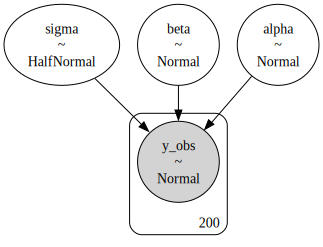

In [13]:
pm.model_to_graphviz(model)

In [14]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
idata.posterior["alpha"].shape

(4, 1000)

In [16]:
idata.posterior["alpha"][0, 0:5]

<xarray.DataArray 'alpha' (draw: 5)>
array([1.02262633, 1.08624876, 0.9854774 , 1.03190702, 1.0723603 ])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4

In [17]:
idata.posterior["alpha"][1, 0:5]

<xarray.DataArray 'alpha' (draw: 5)>
array([1.0140351 , 0.95425721, 0.98107329, 1.01232194, 0.98242989])
Coordinates:
    chain    int64 1
  * draw     (draw) int64 0 1 2 3 4

In [18]:
idata.posterior["beta"].shape

(4, 1000)

In [19]:
data["x"].shape

(200,)

In [20]:
print(*data.x[0:5])

0.0 0.005025125628140704 0.010050251256281407 0.01507537688442211 0.020100502512562814


In [21]:
print(*y[0:5])

1.1523585398772156 0.4900581981360337 1.3953261004157915 1.5004331119644512 0.06468341069820738


In [22]:
print(idata.observed_data.y_obs[0:5].values)

[1.15235854 0.4900582  1.3953261  1.50043311 0.06468341]


In [23]:
idata.posterior["alpha"].mean().item()

0.9864780312574323

In [24]:
idata.posterior["beta"].mean().item()

1.992161902136779

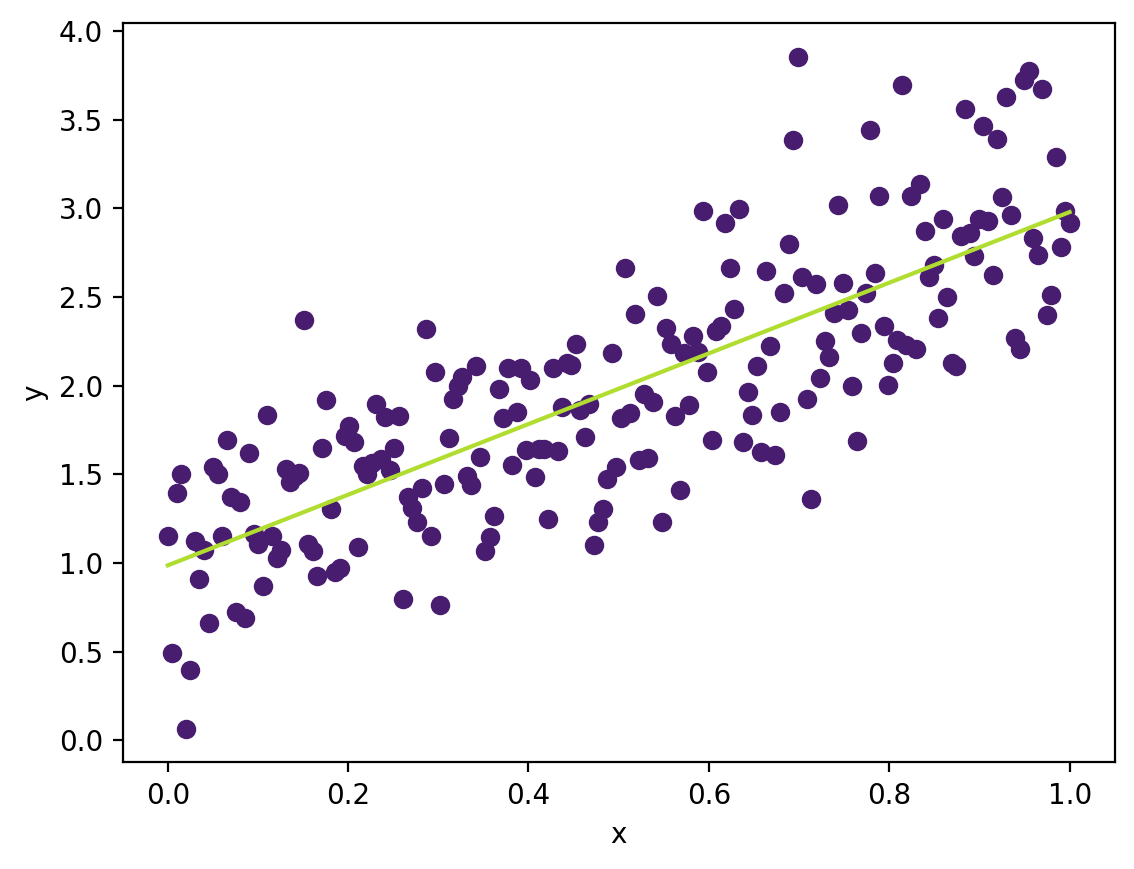

In [25]:
plt.plot(x, y, "C0o")
plt.plot(
    x,
    idata.posterior["alpha"].mean().item()
    + idata.posterior["beta"].mean().item() * x,
    "C3"
)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [26]:
idata.posterior["y_model"] = idata.posterior["alpha"] + idata.posterior[
    "beta"
] * xr.DataArray(x)
idata.posterior["y_model"].shape

(4, 1000, 200)

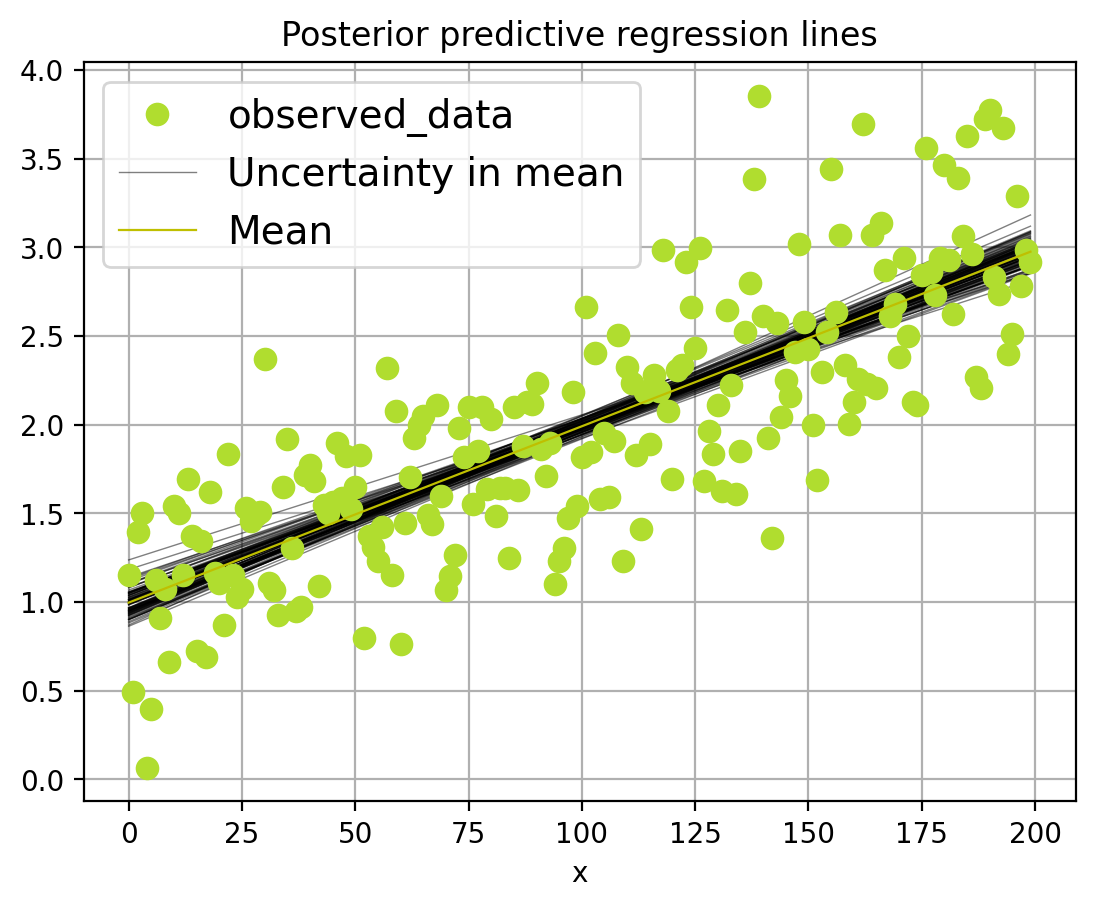

In [27]:
az.plot_lm(idata=idata, y=y, num_samples=100, y_model="y_model")
plt.title("Posterior predictive regression lines")
plt.xlabel("x");

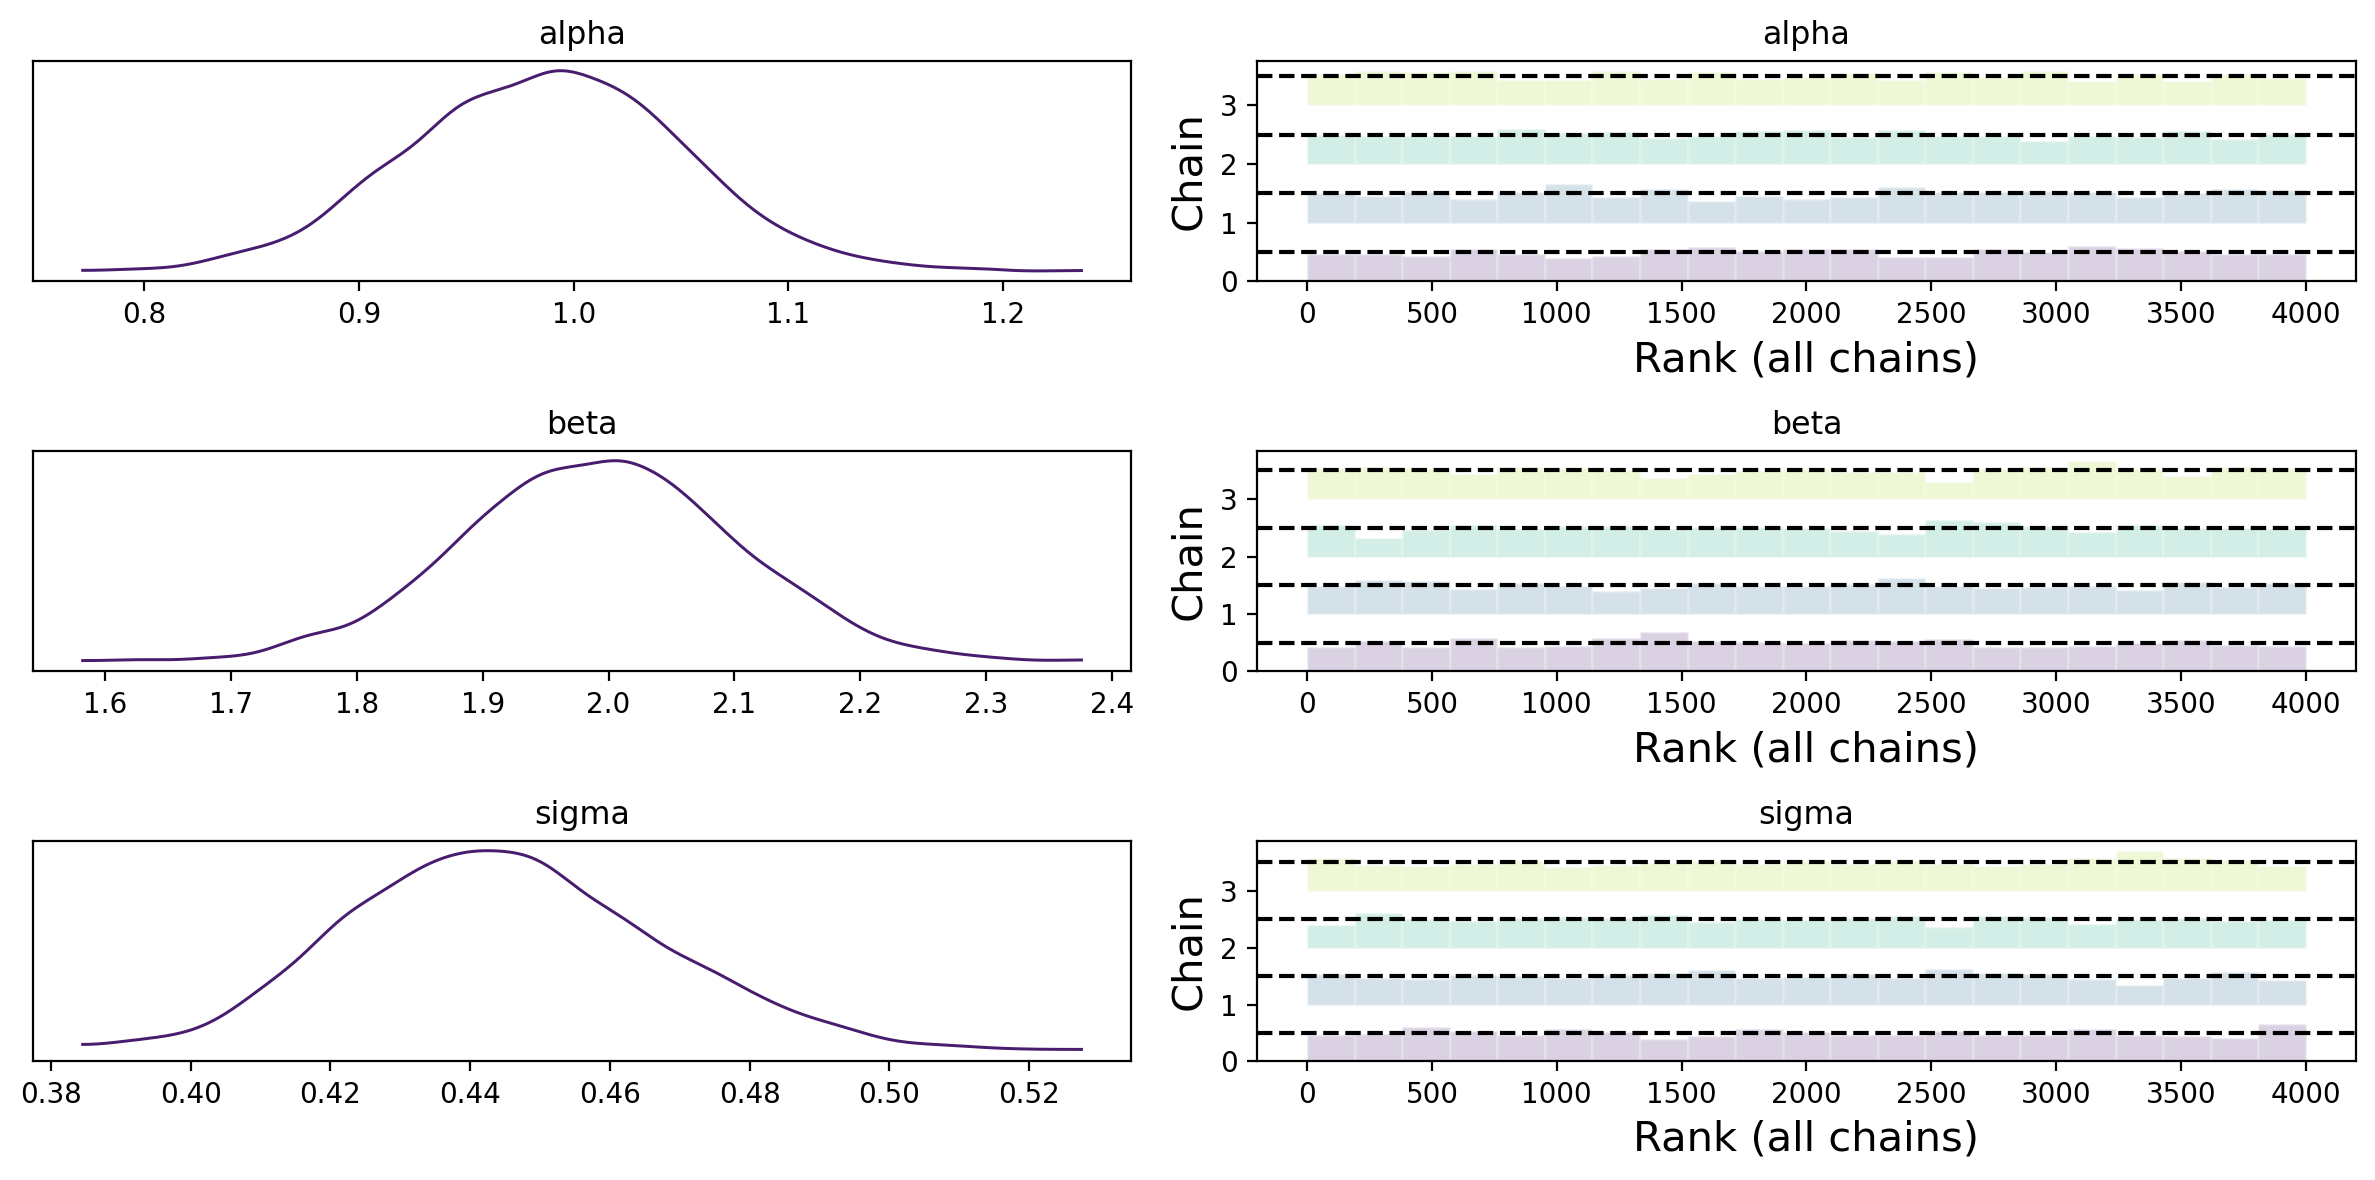

In [28]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(idata, var_names=var_names, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [29]:
params = ["alpha", "beta", "sigma"]
az.summary(idata, var_names = params, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.99,0.06,0.87,1.11,0.0,0.0,1756.19,2031.25,1.0
beta,1.99,0.11,1.80,2.20,0.0,0.0,1725.12,1910.99,1.0
sigma,0.44,0.02,0.41,0.49,0.0,0.0,1899.44,2136.44,1.0


In [30]:
idata.posterior['alpha']

<xarray.DataArray 'alpha' (chain: 4, draw: 1000)>
array([[1.02262633, 1.08624876, 0.9854774 , ..., 0.85652624, 1.00462931,
        0.97126495],
       [1.0140351 , 0.95425721, 0.98107329, ..., 0.89881977, 1.11825202,
        1.11622937],
       [0.92195247, 0.9157914 , 0.99110565, ..., 0.9256711 , 0.9687328 ,
        0.92980079],
       [0.98819532, 0.95267117, 0.98617858, ..., 0.92301859, 0.93356203,
        0.92414514]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [31]:
alpha_array = idata.posterior['alpha'].values
beta_array = idata.posterior['beta'].values

print("Shape of alpha_array:", alpha_array.shape)
print("Shape of beta_array:", beta_array.shape) 

Shape of alpha_array: (4, 1000)
Shape of beta_array: (4, 1000)


In [32]:
# Flatten the 2D arrays into 1D arrays
alpha_flat = alpha_array.ravel()
beta_flat = beta_array.ravel()

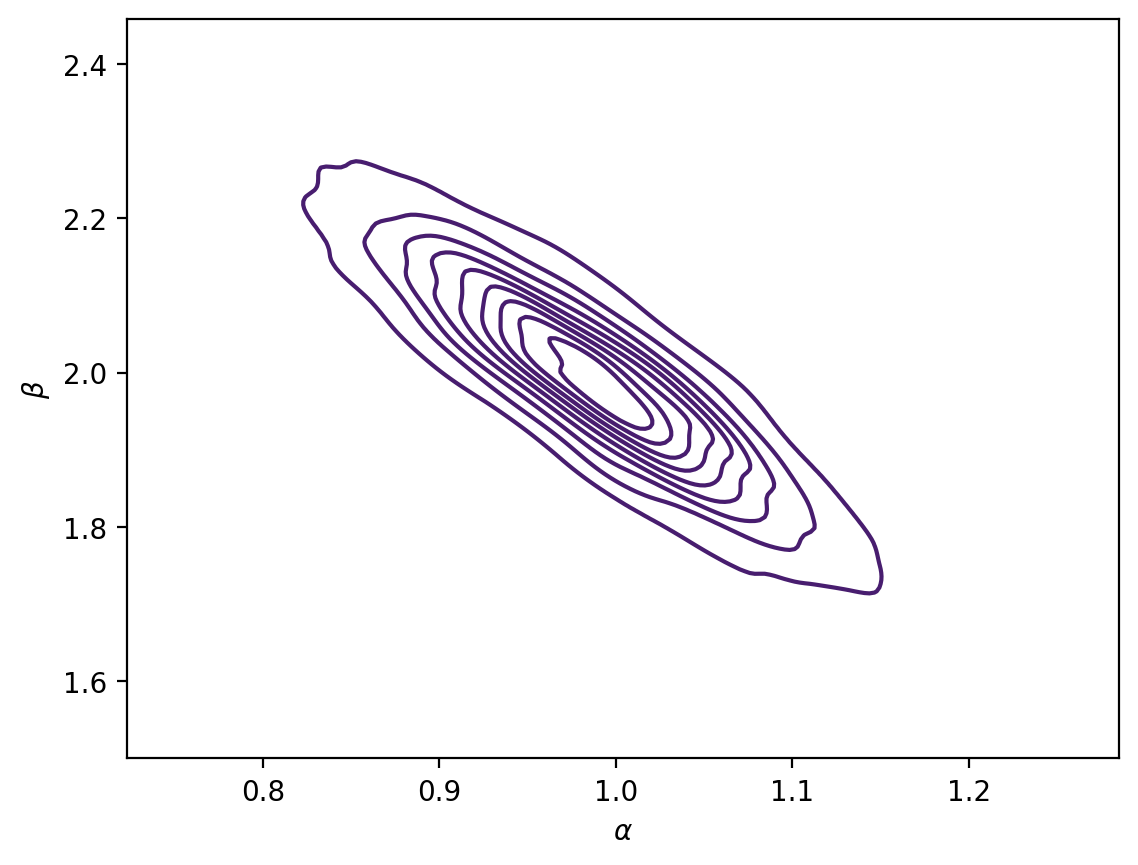

In [33]:
# Create the KDE plot
sns.kdeplot(x=alpha_flat, y=beta_flat)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.show()

In [34]:
with model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [alpha, beta, sigma, y_obs]


In [35]:
prior = prior_samples.prior
prior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    sigma    (chain, draw) float64 2.532 0.4744 0.054 ... 3.965 3.706 3.441
    beta     (chain, draw) float64 0.9723 0.6191 1.292 ... -0.2169 -0.05466
    alpha    (chain, draw) float64 0.3043 1.393 -1.165 ... -2.242 -0.6154 0.6004
Attributes:
    created_at:                 2023-09-17T09:19:15.140327
    arviz_version:              0.16.0
    inference_library:          pymc
    inference_library_version:  5.6.1

In [36]:
x = xr.DataArray(np.linspace(0, 1, 50))
x

<xarray.DataArray (dim_0: 50)>
array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])
Dimensions without coordinates: dim_0

In [37]:
np.array(az.extract_dataset(prior_samples["prior"])["alpha"][:50])

array([ 0.3042541 ,  1.39257156, -1.16455181,  1.04323434,  0.93614848,
        0.57972498,  0.47946014,  0.70006529, -1.92618297,  1.52270821,
       -0.11160722, -1.68550851,  0.20701937, -0.6352095 ,  0.63491562,
        2.18890878,  2.49553057,  0.20878232, -1.08465569, -0.5146556 ,
       -0.39334738,  0.40204974, -0.42552682, -0.20410924, -1.05995153,
       -2.04690121,  0.77100191,  1.22749607,  0.29607439,  1.99660794,
       -0.71135838,  1.60650675, -0.58015384,  0.55758189,  0.22782781,
       -0.13655545, -0.53473883, -0.53584035,  0.78350001,  1.33527311,
        0.21155343,  0.52891751, -0.36507911, -0.21257953, -0.65255089,
        0.76958623, -0.2873632 , -0.767671  ,  1.14108217, -0.50761792])

In [38]:
np.array(az.extract_dataset(prior_samples["prior"])["beta"][:50])

array([ 0.97230129,  0.61908512,  1.2922591 , -1.56646101, -1.04165002,
       -0.39278869,  1.57344308, -1.32104749,  1.26715057,  1.61026741,
       -1.57917267,  0.77217314,  2.19228877,  0.98765628, -0.18836376,
        0.57647873, -1.35072532, -0.00937623,  0.31321278,  0.03633775,
       -0.13167091,  1.24672639, -0.54249711,  1.28982793,  0.13895799,
       -1.23303109,  1.74266316,  0.04143829,  2.1109751 , -0.27114504,
        0.16670063,  0.44544229, -1.0832641 ,  0.56683919,  0.92332376,
       -2.02812767,  1.84095403,  0.00819597, -0.8108199 , -0.06279216,
       -0.47559597, -0.39480636, -0.3289523 ,  0.57140208,  0.35959171,
        0.04917157, -0.16912013, -0.54184428,  0.72562361, -0.2382974 ])

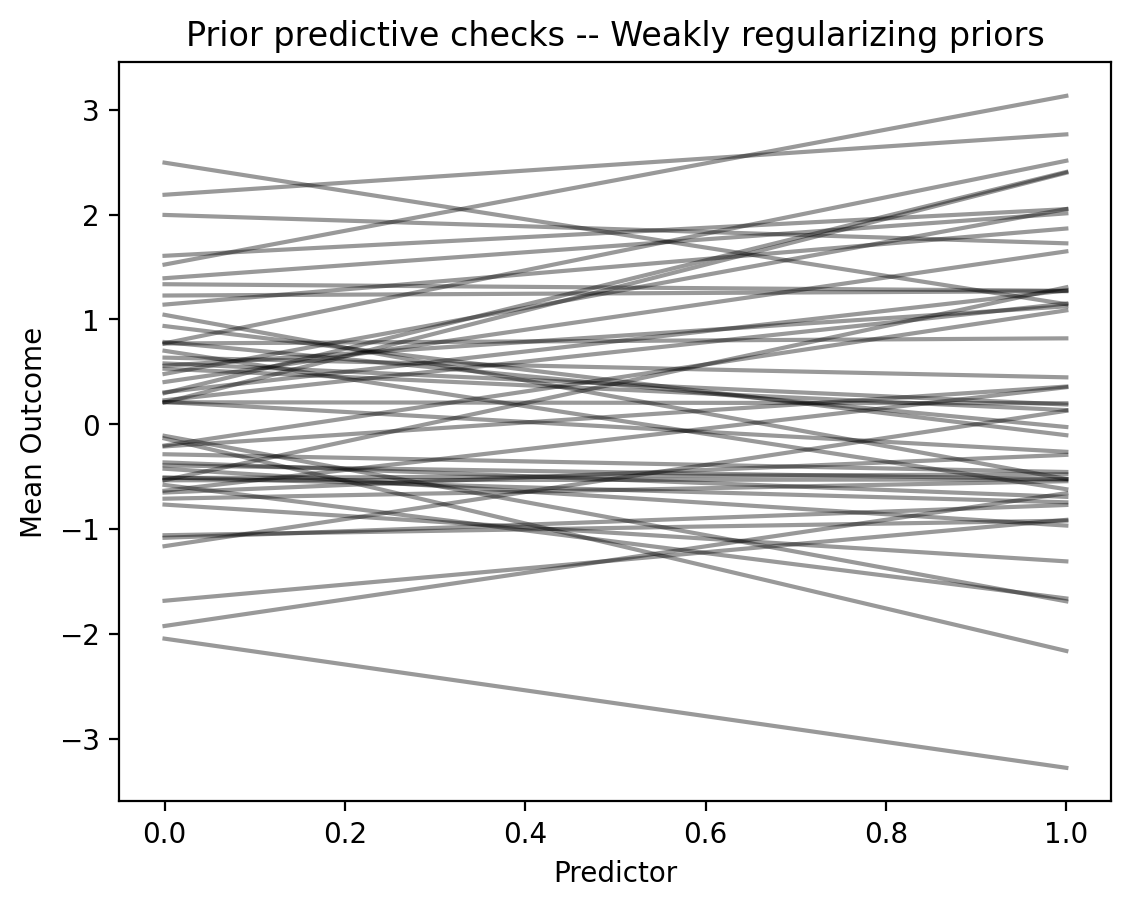

In [39]:
prior_samp_alpha = np.array(az.extract_dataset(prior_samples["prior"])["alpha"][:50])
prior_samp_beta = np.array(az.extract_dataset(prior_samples["prior"])["beta"][:50])

# Plotting the prior samples
for alpha, beta in zip(prior_samp_alpha, prior_samp_beta):
    y = alpha + beta * x
    plt.plot(x, y, c="black", alpha=0.4)

# Setting labels and title
plt.xlabel("Predictor")
plt.ylabel("Mean Outcome")
plt.title("Prior predictive checks -- Weakly regularizing priors")
plt.show()

In [40]:
with model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng);

Sampling: [y_obs]


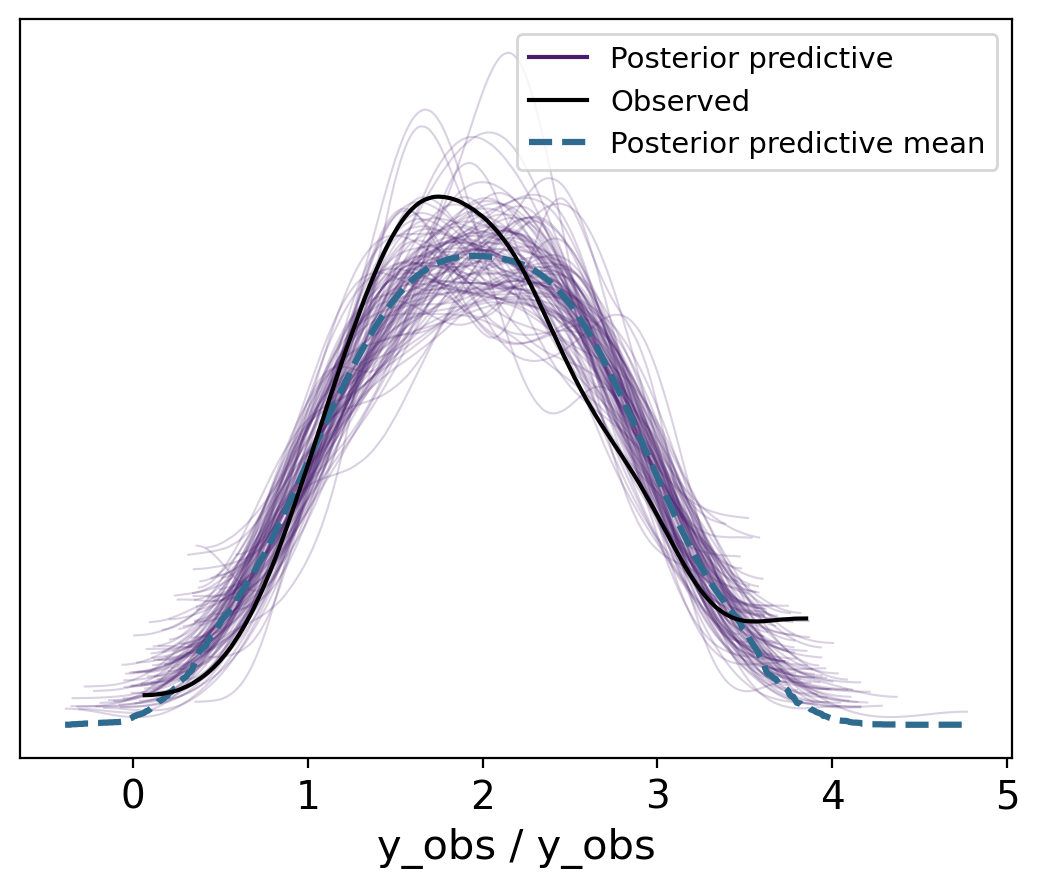

In [41]:
az.plot_ppc(idata, num_pp_samples=100)
plt.show()

In [42]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

xarray    : 2023.6.0
pymc      : 5.6.1
pandas    : 2.0.3
scipy     : 1.10.1
numpy     : 1.25.2
arviz     : 0.16.0
matplotlib: 3.7.2
seaborn   : 0.12.2

